# Image Classificator

In this project, I successfully trained a model capable of distinguishing between six distinct jellyfish species with over 93% accuracy on the validation set and more than 80% accuracy in final predictions. 

The image set I used was sourced from kaggle.com and had undergone some image augmentation, although I applied additional minimum augmentation to ensure diverse sample variety. 

My primary tools for this project were the TensorFlow and Sklearn libraries.



### Import libraries

In [1]:
# Import libraries

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow import keras

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [2]:
# Avoid OOM errors by setting the gpu memory consumption gworth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load the Data

In [3]:
data_dir = "C:\\Users\\rodri.DESKTOP-RAT8004\\Desktop\\Portfolio Projects\\prueba\\data"

In [4]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)

In [5]:
# Create folders for each class to label them
def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path

data_moon = create_images_list(os.path.join(data_dir, "Moon_jellyfish"))
data_barrel = create_images_list(os.path.join(data_dir, "barrel_jellyfish"))
data_blue = create_images_list(os.path.join(data_dir, "blue_jellyfish"))
data_compass = create_images_list(os.path.join(data_dir, "compass_jellyfish"))
data_lions_mane = create_images_list(os.path.join(data_dir, "lions_mane_jellyfish"))
data_mauve_stinger = create_images_list(os.path.join(data_dir, "mauve_stinger_jellyfish"))



# create directories
dir_list = []
data_moon_path = os.path.join(data_dir,"Moon_jellyfish")
dir_list.append(data_moon_path)
data_barrel_path = os.path.join(data_dir,"barrel_jellyfish")
dir_list.append(data_barrel_path)
data_blue_path = os.path.join(data_dir, "blue_jellyfish")
dir_list.append(data_blue_path)
data_compass_path = os.path.join(data_dir, "compass_jellyfish")
dir_list.append(data_compass_path)
data_lions_mane_path = os.path.join(data_dir, "lions_mane_jellyfish")
dir_list.append(data_lions_mane_path)
data_mauve_stinger_path = os.path.join(data_dir, "mauve_stinger_jellyfish")
dir_list.append(data_mauve_stinger_path)

In [6]:
# look-up table
jellyfish_classes = {0:'Moon', 1 : 'Barrel', 2 : 'Blue', 3 : 'Compass', 4 : 'Lion’s mane', 5: 'Mauve stinger'}

data_df = pd.concat([pd.DataFrame({"img" : np.array(data_moon) , "label": 0 }),
                     pd.DataFrame({"img" : np.array(data_barrel) , "label": 1 }),
                     pd.DataFrame({"img" : np.array(data_blue) , "label": 2 }),
                     pd.DataFrame({"img" : np.array(data_compass) , "label": 3 }),
                     pd.DataFrame({"img" : np.array(data_lions_mane) , "label": 4 }),
                     pd.DataFrame({"img" : np.array(data_mauve_stinger) , "label": 5 }) ], ignore_index = True)

data_df = shuffle(data_df, random_state = 5).reset_index(drop = True)
data_df.head()

,img,label
0,C:\Users\rodri.DESKTOP-RAT8004\Desktop\Portfol...,4
1,C:\Users\rodri.DESKTOP-RAT8004\Desktop\Portfol...,3
2,C:\Users\rodri.DESKTOP-RAT8004\Desktop\Portfol...,0
3,C:\Users\rodri.DESKTOP-RAT8004\Desktop\Portfol...,2
4,C:\Users\rodri.DESKTOP-RAT8004\Desktop\Portfol...,0


### Preprocess Data

In [7]:
# splitting into train_df (train and valid) and test_df
test_idx = data_df.shape[0] * 20 // 100  # 10 % for testing 

train_df = data_df[test_idx:].reset_index(drop = True)
test_df = data_df[:test_idx].reset_index(drop = True)


print("train_df (train and val) shape -> ", train_df.shape[0])
print("test_df shape -> ", test_df.shape[0])

train_df (train and val) shape ->  784
test_df shape ->  195


### Deep Learning Model

#### Build Deep Learning Model

In [8]:
#create the model
model = Sequential()
# run every convolution
model.add(Conv2D(8, (3,3), 1, activation= "gelu", input_shape=(40,40,3)))
model.add(BatchNormalization())

model.add(Conv2D(16, (3,3), 1, activation= "gelu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(32, (3,3), 1, activation= "gelu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(64, (3,3), 1, activation= "gelu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), 1, activation= "gelu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation="gelu", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.75))

model.add(Dense(1024, activation="gelu",kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.75))

model.add(Dense(6, activation="softmax"))

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.AdamW(learning_rate = 0.0005,weight_decay = 0.0001),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 8)         224       
                                                                 
 batch_normalization (Batch  (None, 38, 38, 8)         32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 16)        1168      
                                                                 
 batch_normalization_1 (Bat  (None, 36, 36, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 18, 18, 16)        0         
 D)                                                              
                                                        

#### Image preprocessing

In [11]:
IMG_SIZE = (40, 40)

# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label

def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)
    
    return image, label

In [12]:
# Creating test dataset loader and tf.dataset

test_loader = tf.data.Dataset.from_tensor_slices((test_df['img'], test_df['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = tf.data.AUTOTUNE)
                .batch(32)
                .prefetch(tf.data.AUTOTUNE))

#### Train the model

In [13]:
fold_hists = []
test_evals = []
test_preds = []
val_evals = []

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 40
FOLDS = 15

kf = KFold(n_splits = FOLDS, shuffle = True, random_state = 10)

for i, (train_index, val_index) in  enumerate(kf.split(train_df['img'], train_df['label'])):
    
    print('-'*120)
    print(str(i+1) + '.fold training')
    
    X_train_fold = train_df['img'][train_index]
    y_train_fold = train_df['label'][train_index]
    
    X_val_fold = train_df['img'][val_index]
    y_val_fold = train_df['label'][val_index]


    # Creating tf.pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .map(img_preprocessing, num_parallel_calls = AUTO)
                     .map(augmentation, num_parallel_calls = AUTO)
                     .batch(BATCH_SIZE)
                     .shuffle(BATCH_SIZE*5)
                     .prefetch(AUTO))
    
    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
                          .map(img_preprocessing, num_parallel_calls = AUTO)
                          .batch(BATCH_SIZE)
                          .prefetch(AUTO))
    
    #Callback
    logdir = "C:\\Users\\rodri.DESKTOP-RAT8004\\Desktop\\Portfolio Projects\\prueba\\logs"
    mycallback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    
    # Training
    hist = model.fit(train_dataset, 
                     epochs = EPOCHS, 
                     batch_size = BATCH_SIZE, 
                     validation_data = validation_dataset,
                     callbacks=[mycallback],
                     verbose=0)
    
    fold_hists.append(hist)
    
    # train acc & loss
    train_eval = model.evaluate(train_dataset)
    # testing acc & loss (predictions)
    test_eval = model.evaluate(test_dataset)
    test_evals.append(test_eval)
    # validation acc & loss
    val_eval = model.evaluate(validation_dataset)
    
    # print results
    print('Train Loss: {0:.3f}'.format(train_eval[0]), " "*8, 'Train Accuracy: {0:.3f} %'.format(train_eval[1]*100))
    print('Test Loss: {0:.3f}'.format(test_eval[0]), " "*9, 'Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))
    print('Val Loss: {0:.3f}'.format(val_eval[0]), " "*10, 'Val Accuracy: {0:.3f} %'.format(val_eval[1]*100))
    
    # Test set prediction
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    test_preds.append(pred)

------------------------------------------------------------------------------------------------------------------------
1.fold training
2/2 [==============================] - 0s 73ms/step - loss: 2.4816 - accuracy: 0.4906
Train Loss: 2.485          Train Accuracy: 45.964 %
Test Loss: 2.929           Test Accuracy: 30.256 %
Val Loss: 2.482            Val Accuracy: 49.057 %
7/7 [==============================] - 1s 70ms/step
------------------------------------------------------------------------------------------------------------------------
2.fold training
2/2 [==============================] - 0s 73ms/step - loss: 1.9555 - accuracy: 0.5849
Train Loss: 2.234          Train Accuracy: 51.573 %
Test Loss: 2.786           Test Accuracy: 45.128 %
Val Loss: 1.955            Val Accuracy: 58.491 %
7/7 [==============================] - 1s 73ms/step
------------------------------------------------------------------------------------------------------------------------
3.fold training
2/2 [==

2/2 [==============================] - 0s 28ms/step - loss: 0.2702 - accuracy: 0.9808
Train Loss: 0.264          Train Accuracy: 98.224 %
Test Loss: 1.615           Test Accuracy: 81.538 %
Val Loss: 0.270            Val Accuracy: 98.077 %
7/7 [==============================] - 0s 34ms/step
------------------------------------------------------------------------------------------------------------------------
15.fold training
2/2 [==============================] - 0s 28ms/step - loss: 0.2557 - accuracy: 0.9808
Train Loss: 0.257          Train Accuracy: 98.087 %
Test Loss: 1.972           Test Accuracy: 80.513 %
Val Loss: 0.256            Val Accuracy: 98.077 %
7/7 [==============================] - 0s 35ms/step


#### Plot Performance

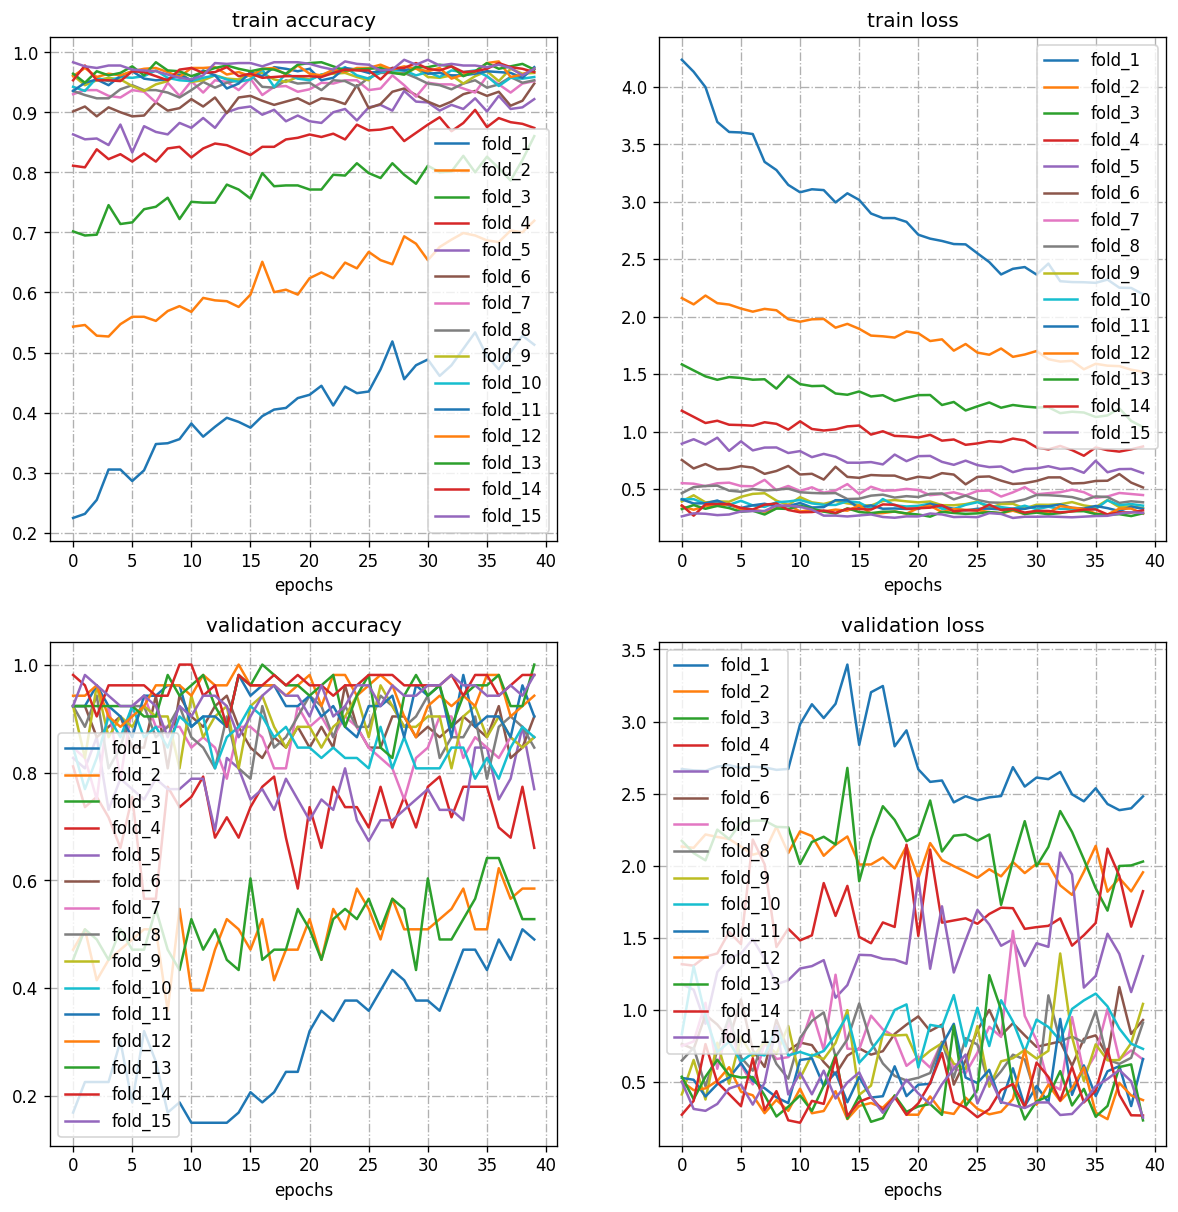

In [14]:
# We created four graphs to visualize the progression of accuracy and loss.
fig, axs = plt.subplots(2,2, figsize = (12,12) ,dpi = 120)

folds_name = []
# first graph
axs[0][0].set_title('train accuracy')
axs[0][0].grid(linestyle = 'dashdot')
axs[0][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][0].plot(fold_hists[i].history['accuracy'])
    folds_name.append('fold_' + str(i + 1) )
axs[0][0].legend(folds_name, fontsize = 10)

# second graph
axs[0][1].set_title('train loss')
axs[0][1].grid(linestyle = 'dashdot')
axs[0][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][1].plot(fold_hists[i].history['loss'])
axs[0][1].legend(folds_name, fontsize = 10)

# third graph
axs[1][0].set_title('validation accuracy')
axs[1][0].grid(linestyle = 'dashdot')
axs[1][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][0].plot(fold_hists[i].history['val_accuracy'])
axs[1][0].legend(folds_name, fontsize = 10)

# fourth graph
axs[1][1].set_title('validation loss')
axs[1][1].grid(linestyle = 'dashdot')
axs[1][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][1].plot(fold_hists[i].history['val_loss'])
axs[1][1].legend(folds_name, fontsize = 10)
plt.show()

### Evaluate Performance

In [15]:
# Calculating the mean of 10 folds predictions

preds = np.max(test_preds, axis = 0)
last_pred = np.argmax(preds, axis = 1)

In [16]:
clf = classification_report(test_df['label'] , last_pred, target_names = list(jellyfish_classes.values()))
print(clf)

               precision    recall  f1-score   support

         Moon       0.66      0.91      0.76        23
       Barrel       0.70      0.94      0.81        33
         Blue       0.96      0.64      0.77        42
      Compass       0.86      0.75      0.80        32
  Lion’s mane       0.93      0.90      0.92        30
Mauve stinger       0.82      0.80      0.81        35

     accuracy                           0.81       195
    macro avg       0.82      0.82      0.81       195
 weighted avg       0.84      0.81      0.81       195



#### Confusion Matrix

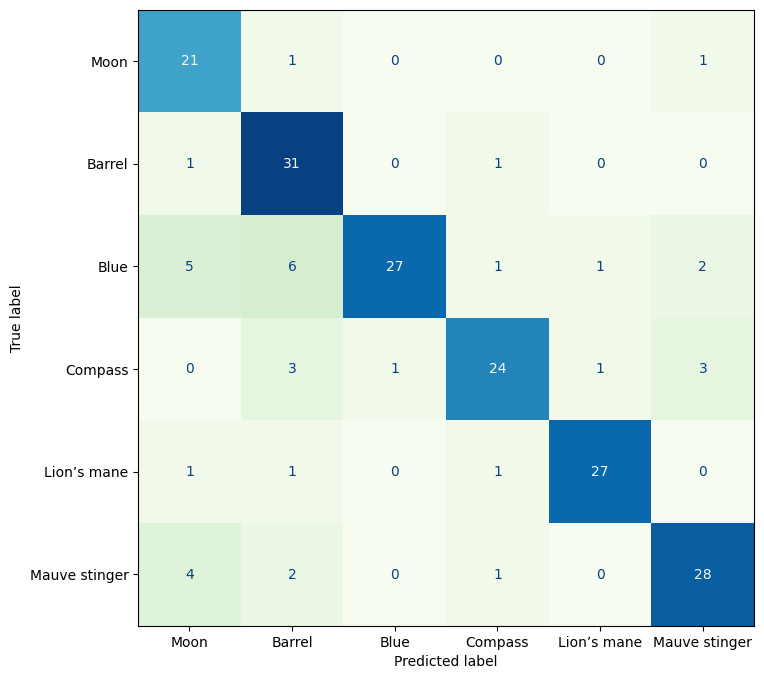

In [17]:
confusion_m = confusion_matrix(test_df['label'] , last_pred)
cm = ConfusionMatrixDisplay(confusion_m, display_labels = list(jellyfish_classes.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm.plot(ax=ax,  cmap = 'GnBu', colorbar = False)
plt.show()

### Predictions

In [18]:
# A function that creates 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
    
def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(last_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(last_pred[idx[i]]) == label:
            axs[i].imshow(img) 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + jellyfish_classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + jellyfish_classes[label], fontsize = 8, color = 'red')

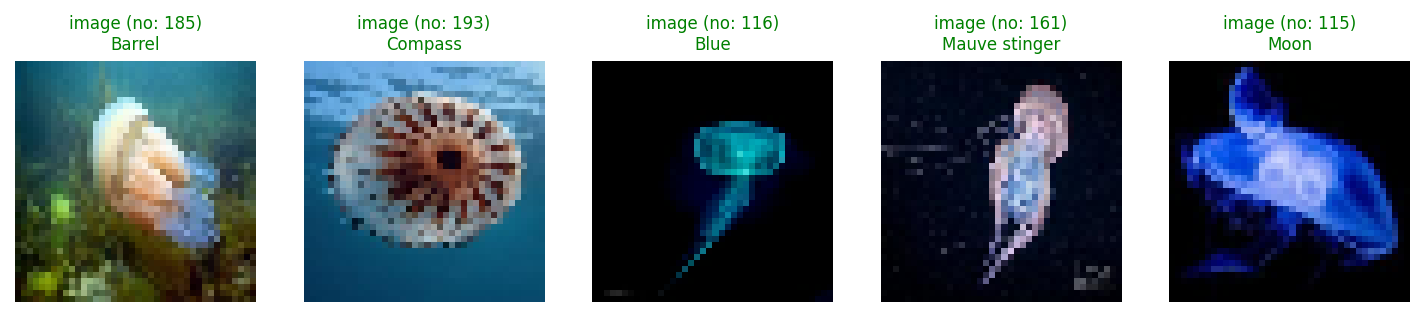

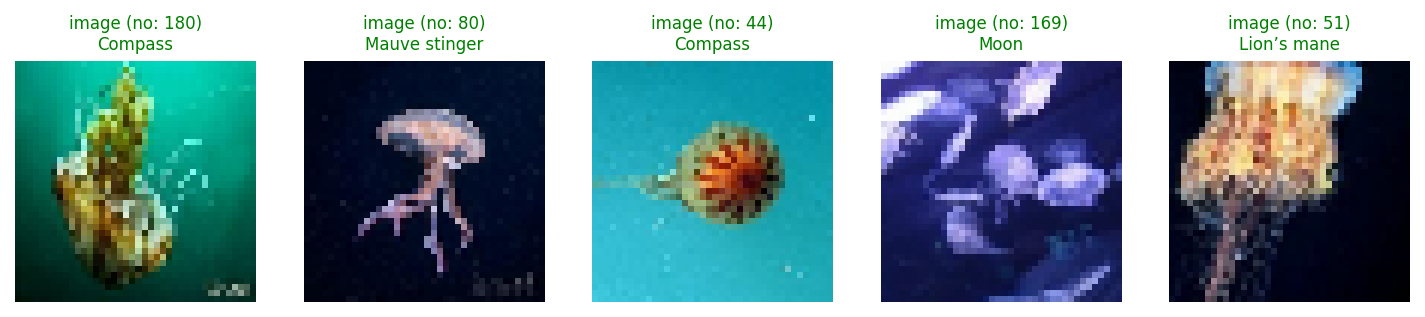

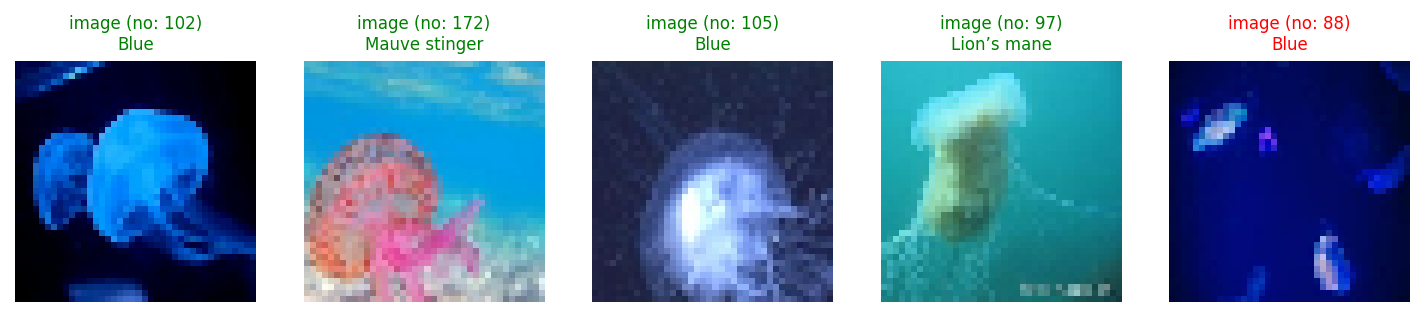

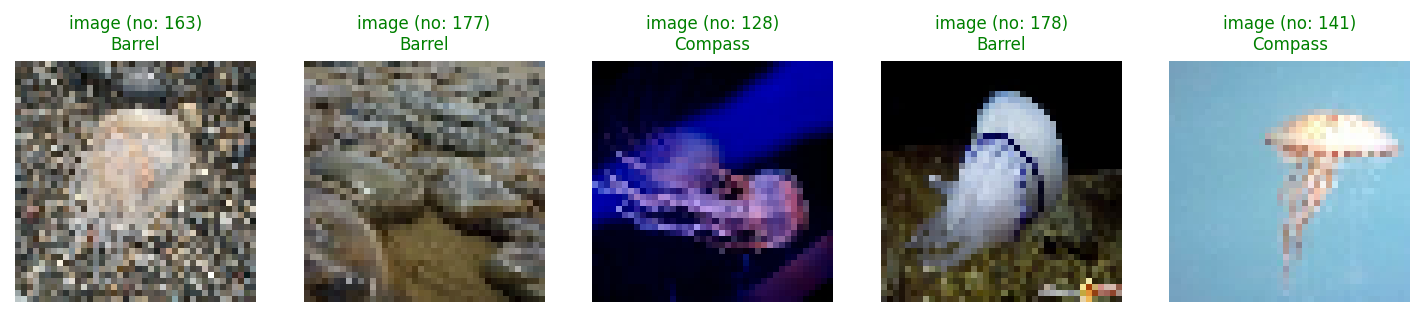

In [19]:
random_test_sample_with_prediction(SEED = 20)
random_test_sample_with_prediction(SEED = 12)
random_test_sample_with_prediction(SEED = 120)
random_test_sample_with_prediction(SEED = 75)